# Lec 35-37: Parallel Universe: Continuation, Model Checking & Probablistic Programming

Jianwen Zhu <jzhu@eecg.toronto.edu>
v2.0, 2024-09

## Forward

We have used a programming language to write a *program* that can be *executed* on a computer to *compute* some outputs given some inputs (possibly from the environment). The program is effectively expressing a *function*, and an *execution* of a program is an *evaluation* of the said function against a concrete instance of input values. The different programming paradigms we learned (and hopefully enjoyed) allow you to express this function more produtively, but it does not change the nature of a program as a function.

Typically, a program consists of many branching (decision) points (this is the essense of control flow), and an execution of the program to evaluate the function follows a specific path of the branching points (ultimately determined by input values), which we call a *program trace*. 

Likely up to this point in your life, your exposure, experience and usage of a program is primarily concerned with function evaluation: after all, we develop programs, debug them, apply them on inputs at production, and get outputs that are hopefully useful. We can it a *forward problem*. 

In the final chapter of this course, we will get exposure to the *backward problem*: *given the output values of a function, what can we say about its inputs?*

To answer the backward problem, we are often concerned with the set of *all* program traces: in fact, the set of all legal program traces defines the full *behavior* of a program. If the one program trace that the forward problem is concerned with is compared to *one universe* with *one thread of life*, then the set of all program traces that the backward problem is concerned with is certainly the *parallel universe* with *tree of lifes*. 

The backward problem has many practical applications. To name a few:

* Model checking: can we formally prove some mathematical properties (correctness specification) of a program? This is accomplished by exhaustively enumerating and checking the properties (thereby proving) on *every* program trace;
  
* Automated test generation: instead of painstakingly (often time hopelessly) creating input test cases that can exercise bugs in the program, can we do the *reversee* and automatically find out input values that allow a program trace to reach an assertion point in the program, and fail that assertion? 

* Generative machine learning: if we can express a system as a function of *hidden (latent) random variables* which we have no knowledge about, but we can oberve the outputs by showing examples, can we learn something about the laten variables and use them to better predict (infer) the output? 

Now fasten the seat belt!

## Agenda

* Continuation: we shall first learn a *new weapon*, although admittedly mind-bending, called continuation. Continuation is often found in the context of functional programming, which boasts the *superpower* to express control flow. 

* Wet lawn problem: we shall leverage all weapons, old and new, throughout this chapter, to solve backward problems on this simple example. 
  
* Model checking: we shall explore methods to exhaustively execute all program traces with specified output.

* Probabalistic programming: we shall explore methods to compute the probabability of an input given an output. 

## Continuation and Continuation Passing Style (CPS)

A *continuation* is a program point expressed as a function. Instead of *goto* (all high-level control flow statements are goto in disguise) a program point, you *apply* the continuation (as a function) to achieve the same effect. Continuation Passing Style (CPS) is a style of functional programming where contro-flow statements are replaced by chained calls to continuation functions, which expect other continuations as parameters. Such replacement can be accomplished mechanically and therefore CPS has been used as intermediate representation by functional programming language compilers, to *desugar* high-level control flow constructs into a minimal representation (this has been repeatedly our theme). The superpower of continuation stem from the fact that one can *explicitly* represent program points and manipulate them as *first-class citizen*. 

Go through the following  [introduction material](./Continuations.ipynb) to learn about continuation. Focus on the section 1, 2, 3, and appreciate how simple it can to build a *theorem prover* in section 7.


## Wet Lawn Example

Consider a front lawn, whose grass may be *wet* because it *rained* or because the
*sprinkler* was on. Since our knowledge is not perfect, we allow for 10% chance that the grass may be wet for some *other* reason. Also, if the rain was *light*, the grass might have dried up by the time we observe it; a sprinkler may too leave the grass dry if, say, water pressure was *low*. We admit these possibilities, assigning them probabilities 10% and 20%, respectively.

We also know from local weather statistics that 30% chances it rains, and the sprinkler is usually on 50% of the time. Both of them are independent boolean random variables.

Now we ask the question: *suppose we observe the grass is wet, what are the chances it rained?*

We can visualize the above statement as follows: 

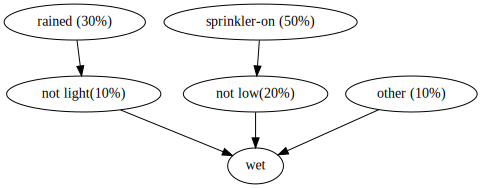

In [1]:
from graphviz import Digraph

# Create Digraph object
dot = Digraph()

dot.node( '1', 'rained (30%)' )
dot.node( '2', 'not light(10%)' )
dot.node( '3', 'sprinkler-on (50%)' )
dot.node( '4', 'not low(20%)' )
dot.node( '5', 'other (10%)' )
dot.node( '9', 'wet' )
dot.edges( ['12', '29', '34', '49', '59'] )

dot

## Model Checking

Let's start by answering a somewhat simpler question: *suppose we observe the grass is wet, what are the set of all possible reasons?* 

You might be able to answer the question right away given the size of the problem is small, but we are looking for a general method to answer all such questions. 

It is *straightforward* to express the forward problem as a program: to compute the effective: wether grass is wet, given concrete values of causes. It is much more difficult to *enumerate* all causes from the same program. It turns out we can use continuation.

### Using fork() as Continuation

Let's solve the model checking problem using C.

In [2]:
%%writefile grass.c
#include <stdbool.h>
#include <stdlib.h>
#include <stdio.h>

extern bool flip(const double p);

void grass_model ( void ) {
    bool rain = flip(0.3);
    bool sprinkler = flip(0.5);
    bool light = flip(0.1);
    bool low = flip(0.2);
    bool other = flip(0.1);

    bool grass_is_wet = (!light && rain) || (!low && sprinkler) || other;
    if( grass_is_wet )
        printf("rain=%c sprinkler=%c light=%c low=%c other=%c\n", 
            rain ? 'T' : 'F', sprinkler ? 'T' : 'F',
            light ? 'T' : 'F', low ? 'T' : 'F', other ? 'T' : 'F'
            );
}

Overwriting grass.c


No surpise here. But here comes the fun part: on every decision at flip(), which may change the behavior and outcome of the computation, we create a *parallel universe*, using fork(), which only differ by the outcome of flip()! fork() is indeed a *perfect* implementation of *continuation* is C. 

In [3]:
%%writefile run-fork.c
#include <stdbool.h>
#include <unistd.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/wait.h>

extern void grass_model( void );

bool flip(const double p) {
    return fork() ? true : false;
}

int main(void) {
    int status;
    grass_model();
    while (wait(&status) > 0)
         ;
    return 0;
}

Overwriting run-fork.c


In [18]:
!gcc -o run-fork run-fork.c grass.c
!time ./run-fork

rain=T sprinkler=T light=T low=T other=T
rain=T sprinkler=T light=F low=T other=T
rain=T sprinkler=F light=T low=T other=T
rain=T sprinkler=T light=T low=F other=T
rain=F sprinkler=T light=T low=T other=T
rain=T sprinkler=T light=F low=T other=F
rain=T sprinkler=T light=T low=F other=F
rain=F sprinkler=T light=T low=F other=T
rain=T sprinkler=T light=F low=F other=T
rain=F sprinkler=T light=F low=T other=T
rain=F sprinkler=F light=F low=T other=T
rain=T sprinkler=F light=F low=T other=T
rain=F sprinkler=F light=T low=T other=T
rain=T sprinkler=F light=F low=T other=F
rain=T sprinkler=T light=F low=F other=F
rain=F sprinkler=T light=F low=F other=F
rain=F sprinkler=F light=F low=F other=T
rain=T sprinkler=F light=T low=F other=T
rain=T sprinkler=F light=F low=F other=T
rain=T sprinkler=F light=F low=F other=F
rain=F sprinkler=T light=F low=F other=T
rain=F sprinkler=F light=T low=F other=T
rain=F sprinkler=T light=T low=F other=F

real	0m0.003s
user	0m0.011s
sys	0m0.000s


### Using Python Coroutine as Continuation

This looks very neat, except one problem: the fork() system call is very *expensive*! It involves creating a new process, by cloning all system resources, including address maps, memories etc of the parent process, on every flip() call.  

Can we do something better? 

Last week we deloped a tiny OS using Python coroutines, we could implement a *light weight* fork on our own tiny OS (our 7th attempt, enclosed in pyos7.py).

All we need to do is to add a new system call, mimicking fork(). Here we implement Flip directly as the system call. The trick is to *clone* the current coroutine using deep copy, and manipulate sendval so that it assume True or False value depending on whether it is parent or child.

In [10]:
%%writefile grass.py

from pyos7 import *
import copy

# Implementing fork() system call
class Flip(SystemCall):
    def __init__( self, prob ) :
        self.prob = prob
        
    def handle(self):
        # self.task has task of parent
        cloned_target = copy.deepcopy( self.task.target ) 
        cloned_tid = self.sched.new( cloned_target )
        cloned_task = self.sched.taskmap[cloned_tid]
        cloned_task.sendval = False
        self.task.sendval = True
        self.sched.schedule( self.task )

Overwriting grass.py


We can then create the grass lawn model by rewriting it in Python.

In [11]:
%%writefile -a grass.py

def grass_model() :
    rain = yield Flip( 0.3 )
    sprinkler = yield Flip( 0.5 )
    light = yield Flip( 0.1 )
    low = yield Flip( 0.2 )
    other = yield Flip( 0.1 )
    grass_is_wet = (not light and rain) or (not low and sprinkler) or other
    if grass_is_wet :
        print( "rain=%s sprinkler=%s light=%s low=%s other=%s" % (rain, sprinkler, light, low, other) )
   
sched = Scheduler()
sched.new( grass_model() )
sched.mainloop()

Appending to grass.py


In [12]:
!python grass.py

Traceback (most recent call last):
  File "/Users/jzhu/teaching/ece326/2024-fall-ece326-jzhu/notes/grass.py", line 31, in <module>
    sched.mainloop()
  File "/Users/jzhu/teaching/ece326/2024-fall-ece326-jzhu/notes/pyos7.py", line 102, in mainloop
    result.handle()
  File "/Users/jzhu/teaching/ece326/2024-fall-ece326-jzhu/notes/grass.py", line 12, in handle
    cloned_target = copy.deepcopy( self.task.target ) 
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/copy.py", line 161, in deepcopy
    rv = reductor(4)
         ^^^^^^^^^^^
TypeError: cannot pickle 'generator' object


Unfortunately, deepcopy() for coroutine does not work in Standard python! It turns out the only python system where deepcopy() works for coroutine is a environment called PyPy, and it only worked for Python 2.7!


In [19]:
!time pypy grass.py

rain=False sprinkler=False light=False low=False other=True
rain=False sprinkler=False light=False low=True other=True
rain=False sprinkler=False light=True low=False other=True
rain=False sprinkler=False light=True low=True other=True
rain=False sprinkler=True light=False low=False other=False
rain=False sprinkler=True light=False low=False other=True
rain=False sprinkler=True light=False low=True other=True
rain=False sprinkler=True light=True low=False other=False
rain=False sprinkler=True light=True low=False other=True
rain=False sprinkler=True light=True low=True other=True
rain=True sprinkler=False light=False low=False other=False
rain=True sprinkler=False light=False low=False other=True
rain=True sprinkler=False light=False low=True other=False
rain=True sprinkler=False light=False low=True other=True
rain=True sprinkler=False light=True low=False other=True
rain=True sprinkler=False light=True low=True other=True
rain=True sprinkler=True light=False low=False other=False
rai

### Using C Coroutine as Continuation and Hundred-Line TinyOS

This of course is not a nice situation, but this is not going to stop us! Being fearless computer engineers, let's implement our own tiny operating system using coroutines in C. Do you still remembers the *Duff's Device*? 

Being creative in naming, we are going to call our creation TinyOS. We start with a header file that defines the necessary data structure and API (the contract to the user). The key data structure is tiny_context_t, which captures everything important for a task. 

In [14]:
%%writefile tinyos.h
/* 
 * FILE: tinyos.h
 * Author: Jianwen Zhu
 */
#ifndef TINYOS_H
#define TINYOS_H

#include <stdbool.h>
#include <stdlib.h>
#include <stdio.h>

typedef struct _tiny_context_t tiny_context_t;

typedef void (*tiny_target_t)( tiny_context_t* ctx );

struct _tiny_context_t {
    tiny_context_t* next;
    tiny_target_t target;    /* coroutine */
    int taskid;  /* task ID */
    int size;    /* size of context */
    int state;   /* capture the program point */
    int sendval; /* return value from syscall */
};

/* coroutine macros using Duff's device */

#define crBegin(ctx) switch((ctx)->state) { case 0:
#define crYield(ctx) do { (ctx)->state=__LINE__; return; \
                         case __LINE__:; } while (0)
#define crEnd(ctx) }
#define crFork(ret, ctx) do { (ctx)->state=__LINE__; tiny_clone(ctx); return; case __LINE__:; ret = !!(ctx)->sendval; } while( 0 ) 

/* minimal API */

extern int tiny_spawn( tiny_target_t func, int context_size );
extern int tiny_clone( tiny_context_t* me );

extern void tiny_init( void );
extern void tiny_mainloop( void );
extern void tiny_fini( void );

#endif

Overwriting tinyos.h


Now let's actually implement the APIs.

In [ ]:
%%writefile tinyos.c
/* 
 * FILE: tinyos.c
 * Author: Jianwen Zhu
 */
#include <stdbool.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
     
#include "tinyos.h"

static tiny_context_t* _task_head;
static int             _task_id;

static tiny_context_t* task_push( tiny_context_t* task ) {
    task->next = _task_head;
    _task_head = task;
}

static tiny_context_t* task_pop( void ) {
    tiny_context_t* task;

    task = _task_head;
    if( task )
        _task_head = task->next;
    return task;
}

int tiny_spawn( tiny_target_t func, int context_size ) {
    tiny_context_t*  ctx;

    ctx = malloc( context_size );
    if( ctx == NULL ) return -1;

    ctx->size = context_size;
    ctx->state = 0;
    ctx->target = func;
    ctx->taskid = _task_id ++;
    ctx->sendval = -1;
    task_push( ctx );

    return 0;
}

int tiny_clone( tiny_context_t* me ) {
    tiny_context_t* clone;

    clone = malloc( me->size );
    if( clone == NULL )
        return -1;
    memmove( (void*)clone, (void*)me, me->size );
    clone->taskid = _task_id ++;    
    clone->sendval = 0;
    task_push( clone );

    me->sendval = clone->taskid;
    task_push( me );

    return 0;          
}

void tiny_init( void ) {
    _task_head = NULL;
    _task_id = 0;
}
              
void tiny_mainloop( void ) {
    tiny_context_t* task;
    
    while( (task = task_pop()) )
        task->target( task );
}

void tiny_fini( void ) {
}

In [15]:
!wc -l tinyos.h tinyos.c

  42 tinyos.h
  75 tinyos.c
 117 total


Hey, this is a multitask operating system, with the key capabilities of:
* spawning a top-level task (like what you do in shell);
* forking a child task (the main workhorse as continuation);
* cooperating CPU sharing;
  
only in 117 lines of code!

Let's see if it can accomplish the same using the full-fledged, million-line Linux with 
fork().

In [16]:
%%writefile run-tinyos1.c
#include <stdbool.h>
#include <unistd.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/wait.h>

#include "tinyos.h"

typedef struct {
    tiny_context_t base;
    bool rain;
    bool sprinkler;
    bool light;
    bool low;
    bool other;
} grass_context_t;

#define GRASS_CONTEXT(ctx) ((grass_context_t*)ctx)

#define FLIP( p, ret ) crFork(ret, ctx) 

void grass_model ( tiny_context_t* ctx ) {
    grass_context_t*  me = GRASS_CONTEXT(ctx);

    crBegin( ctx );

    FLIP( 0.3, me->rain );
    FLIP( 0.5, me->sprinkler );
    FLIP( 0.1, me->light );
    FLIP( 0.2, me->low );
    FLIP( 0.1, me->other );

    bool grass_is_wet = (!me->light && me->rain) || (!me->low && me->sprinkler) || me->other;
    if( grass_is_wet )
        printf("rain=%c sprinkler=%c light=%c low=%c other=%c\n", 
            me->rain ? 'T' : 'F', me->sprinkler ? 'T' : 'F',
            me->light ? 'T' : 'F', me->low ? 'T' : 'F', me->other ? 'T' : 'F'
            );

    crEnd( ctx );
}

int main(void) {
    tiny_init();
    tiny_spawn( grass_model, sizeof(grass_context_t) );
    tiny_mainloop();
    tiny_fini();
    return 0;
}

Overwriting run-tinyos1.c


In [17]:
!gcc -o run-tinyos1 run-tinyos1.c tinyos.c
!time ./run-tinyos1

rain=T sprinkler=T light=T low=T other=T
rain=T sprinkler=T light=T low=F other=T
rain=T sprinkler=T light=T low=F other=F
rain=T sprinkler=T light=F low=T other=T
rain=T sprinkler=T light=F low=T other=F
rain=T sprinkler=T light=F low=F other=T
rain=T sprinkler=T light=F low=F other=F
rain=T sprinkler=F light=T low=T other=T
rain=T sprinkler=F light=T low=F other=T
rain=T sprinkler=F light=F low=T other=T
rain=T sprinkler=F light=F low=T other=F
rain=T sprinkler=F light=F low=F other=T
rain=T sprinkler=F light=F low=F other=F
rain=F sprinkler=T light=T low=T other=T
rain=F sprinkler=T light=T low=F other=T
rain=F sprinkler=T light=T low=F other=F
rain=F sprinkler=T light=F low=T other=T
rain=F sprinkler=T light=F low=F other=T
rain=F sprinkler=T light=F low=F other=F
rain=F sprinkler=F light=T low=T other=T
rain=F sprinkler=F light=T low=F other=T
rain=F sprinkler=F light=F low=T other=T
rain=F sprinkler=F light=F low=F other=T

real	0m0.001s
user	0m0.001s
sys	0m0.000s


It not only produces exactly the same output, but runs more than 100X faster!

## Probablistic Inference

We now turn to the original question: given the observation that the grass was wet, what is the probability that it rained? 

Using conventional thinking, we could apply the *Monte Carlo* method, which basically draw
many, many samples of inputs, and run the forward problem again and again. This method, of course, is notoriously very slow.

We can do smarter. It turns out we only need to modify our model checking method slightly, by remembering the cumulative probabilities of each enumerated case. 

### Probablistic Programming in C

In [20]:
%%writefile run-tinyos2.c
#include <stdbool.h>
#include <unistd.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/wait.h>

#include "tinyos.h"

typedef struct {
    tiny_context_t base;
    bool rain;
    bool sprinkler;
    bool light;
    bool low;
    bool other;
    double prob;  // newly added
} grass_context_t;

#define GRASS_CONTEXT(ctx) ((grass_context_t*)ctx)

#define FLIP( p, ret ) do { crFork(ret, ctx); GRASS_CONTEXT(ctx)->prob *= ret ? p : (1-p); } while( 0 )

void grass_model ( tiny_context_t* ctx ) {
    grass_context_t*  me = GRASS_CONTEXT(ctx);

    crBegin( ctx );
    me->prob = 1.0;

    FLIP( 0.3, me->rain );
    FLIP( 0.5, me->sprinkler );
    FLIP( 0.1, me->light );
    FLIP( 0.2, me->low );
    FLIP( 0.1, me->other );

    bool grass_is_wet = (!me->light && me->rain) || (!me->low && me->sprinkler) || me->other;
    if( grass_is_wet )
        printf("%g rain=%c sprinkler=%c light=%c low=%c other=%c\n", me->prob, 
            me->rain ? 'T' : 'F', me->sprinkler ? 'T' : 'F',
            me->light ? 'T' : 'F', me->low ? 'T' : 'F', me->other ? 'T' : 'F'
            );

    crEnd( ctx );
}

int main(void) {
    tiny_init();
    tiny_spawn( grass_model, sizeof(grass_context_t) );
    tiny_mainloop();
    tiny_fini();
    return 0;
}

Overwriting run-tinyos2.c


In [21]:
!gcc -o run-tinyos2 run-tinyos2.c tinyos.c
!./run-tinyos2

0.0003 rain=T sprinkler=T light=T low=T other=T
0.0012 rain=T sprinkler=T light=T low=F other=T
0.0108 rain=T sprinkler=T light=T low=F other=F
0.0027 rain=T sprinkler=T light=F low=T other=T
0.0243 rain=T sprinkler=T light=F low=T other=F
0.0108 rain=T sprinkler=T light=F low=F other=T
0.0972 rain=T sprinkler=T light=F low=F other=F
0.0003 rain=T sprinkler=F light=T low=T other=T
0.0012 rain=T sprinkler=F light=T low=F other=T
0.0027 rain=T sprinkler=F light=F low=T other=T
0.0243 rain=T sprinkler=F light=F low=T other=F
0.0108 rain=T sprinkler=F light=F low=F other=T
0.0972 rain=T sprinkler=F light=F low=F other=F
0.0007 rain=F sprinkler=T light=T low=T other=T
0.0028 rain=F sprinkler=T light=T low=F other=T
0.0252 rain=F sprinkler=T light=T low=F other=F
0.0063 rain=F sprinkler=T light=F low=T other=T
0.0252 rain=F sprinkler=T light=F low=F other=T
0.2268 rain=F sprinkler=T light=F low=F other=F
0.0007 rain=F sprinkler=F light=T low=T other=T
0.0028 rain=F sprinkler=F light=T low=F 

It works and we now have each printed case prefixed with a probability. We only need to do some *post-processing*.

In [22]:
!./run-tinyos2 | awk  '{r[$2] += $1}; END {printf "T: %g; F: %g",r["rain=T"],r["rain=F"]}'

T: 0.2838; F: 0.322

What we have done by tallying up the different cases for rain=T and rain=F is in fact computing the *marginal probabilities* of random variable of interest. The result is basically saying that 28.38% chance it is raining, and 32.2% chance it is not raining, and remaining chances are the "don't cares" where the lawn is not wet. So conditional on the observation that the lawn is wet, the probabability that it rained is:

In [23]:
0.2838 / (0.2838 + 0.322)

0.4684714427203697

If you recall from your probability or machine learning class, this is Bayes' theorem in action!

### Probablistic Programming in Python

We are still uncomfortable with not being able to implementing model checking, and therefore probablistic programmming, just because of the lack of deep copy for coroutine/generators. 

Didn't we already learned continuation passing style (CPS)? CPS counts on nothing but the minimal, one and only, lambda calulus!

In [ ]:
%%writefile run-cps.py

unexplored_future = []

def flip_cps( prob, p, k ) :
    unexplored_future.append( lambda : k(prob*p, True) )
    unexplored_future.append( lambda : k(prob*(1-p), False) )

def sched_mainloop() :    
    while len( unexplored_future ) > 0 :
        task = unexplored_future.pop( 0 )
        task()

def grass_is_wet( prob, rain, light, sprinkler, low, other, k ) :
    if (not light and rain) or (not low and sprinkler) or other :
        k( "%g rain=%s sprinkler=%s light=%s low=%s other=%s" % (prob, rain, sprinkler, light, low, other) )
    
def grass_cps( k ) :
    flip_cps( 1.0, 0.3, lambda prob, rain : 
        flip_cps( prob, 0.5, lambda prob, sprinkler :
            flip_cps( prob, 0.1, lambda prob, light :
                     flip_cps( prob, 0.2, lambda prob, low :
                          flip_cps( prob, 0.1, lambda prob, other :
                              grass_is_wet( prob, rain, light, sprinkler, low, other, k ) )))))

def k_print( s ) :
    print( s )

grass_cps( k_print )
sched_mainloop()

In [24]:
!python run-cps.py

0.0003 rain=True sprinkler=True light=True low=True other=True
0.0012 rain=True sprinkler=True light=True low=False other=True
0.0108 rain=True sprinkler=True light=True low=False other=False
0.0027 rain=True sprinkler=True light=False low=True other=True
0.0243 rain=True sprinkler=True light=False low=True other=False
0.0108 rain=True sprinkler=True light=False low=False other=True
0.0972 rain=True sprinkler=True light=False low=False other=False
0.0003 rain=True sprinkler=False light=True low=True other=True
0.0012 rain=True sprinkler=False light=True low=False other=True
0.0027 rain=True sprinkler=False light=False low=True other=True
0.0243 rain=True sprinkler=False light=False low=True other=False
0.0108 rain=True sprinkler=False light=False low=False other=True
0.0972 rain=True sprinkler=False light=False low=False other=False
0.0007 rain=False sprinkler=True light=True low=True other=True
0.0028 rain=False sprinkler=True light=True low=False other=True
0.0252 rain=False sprinkle

In [25]:
!python run-cps.py | awk  '{r[$2] += $1}; END {printf "T: %g; F: %g",r["rain=True"],r["rain=False"]}'

T: 0.2838; F: 0.322

How many lines of code did we use?

In [26]:
!wc -l run-cps.py

29 run-cps.py


We now attain a new record: the whole program, relying on only lambda function, is less than *30 lines of code*! And recall that lambda calculus only has *3 rules* in total in the entire language!

### Recap

What exactly have we learned? 

* Continuation: explict program point as function;
  
* Continuation Passing Style: desugar all control flow programming constructs, including sequencing, if-then-else, loop, exception handling, concurrent programming, into one cannonical form;

* Being fearless as UofT engineer: programming language paradigms are tools for thought, not scary creatures that just tortures your mind. Always apply first principle, cut to the chase: you can write an OS in 100 lines, and write a complete machine learn program in 30 lines of lambda calculus (with zero libraries). 